In this notebook we'll explore the solution found by our classifier.

In [1]:
#!pip install seaborn

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

import utils
import rnn

%load_ext autoreload
%matplotlib inline

Using TensorFlow backend.
/Users/davidbiagioni/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [71]:
%autoreload
import utils
import rnn

### Re-create the training data using saved model params

In [3]:
# Pick a model to load and extract the hyperparams.

#model_name = 'models/64_64_64_0.5_False_20_20000_0.3_64_0.0_002_0.53010_0.73065_titles.h5'
model_name = 'models/64_64_64_0.5_False_20_34414_0.1_64_0.0_1_titles_001_0.52713_0.73474_titles.h5'

gru_dim, embed_dim, dense_dim, dropout, bidirectional, maxlen, topn, test_size, batch_size = \
  utils.parse_model_name(model_name)
  
# Load the keras model
model = load_model(model_name)

In [4]:
%%time

# Load the source data frame

filepath = '../data/data-True-0.pkl'
df, keep_stops, min_sents, vocab, w2i, i2w = utils.read_dataset(filepath)

CPU times: user 3.25 s, sys: 70 ms, total: 3.32 s
Wall time: 3.32 s


In [5]:
%%time

# Filter out uncommon words using parameters parsed from model name.

df['encoded_text'] = utils.filter_top_words(df['encoded_text'].tolist(), topn)

CPU times: user 111 ms, sys: 5.84 ms, total: 117 ms
Wall time: 115 ms


In [6]:
# Create input/output data

X = pad_sequences(df['encoded_text'], maxlen=maxlen, value=topn, 
                  padding='post', truncating='post')

Y = df['encoded_label'].tolist()

### High-level view of data

In [67]:
counts = df['domain'].value_counts()[:30]
freq =  1. * counts / df.shape[0]
summary = pd.concat([counts, freq], axis=1)
summary.columns = ['Num articles', 'Relative Frequency']

labels = []
for idx in summary.index:
  summary.ix[idx, 'Label'] = df[df['domain'] == idx]['label'].iloc[0]

summary.to_csv('/Users/davidbiagioni/Desktop/data.csv')

In [7]:
# Get output probabilities for every observation.

df['prob'] = model.predict(X)

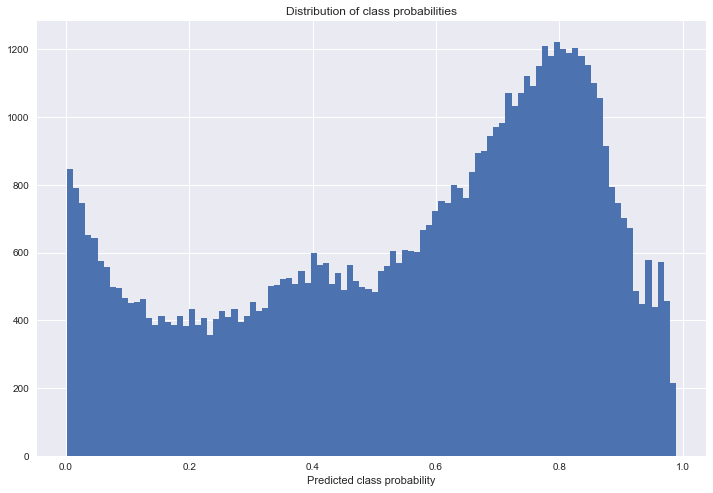

In [8]:
# Look at distribution.  There are some funny extreme modes we should try to understand.

fig, ax = plt.subplots()
ax.set_xlabel('Predicted class probability')
ax = df['prob'].hist(bins=100, figsize=(12, 8), ax=ax)
ax = ax.set_title('Distribution of class probabilities')

In [8]:
sn.color_palette()[1]

(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

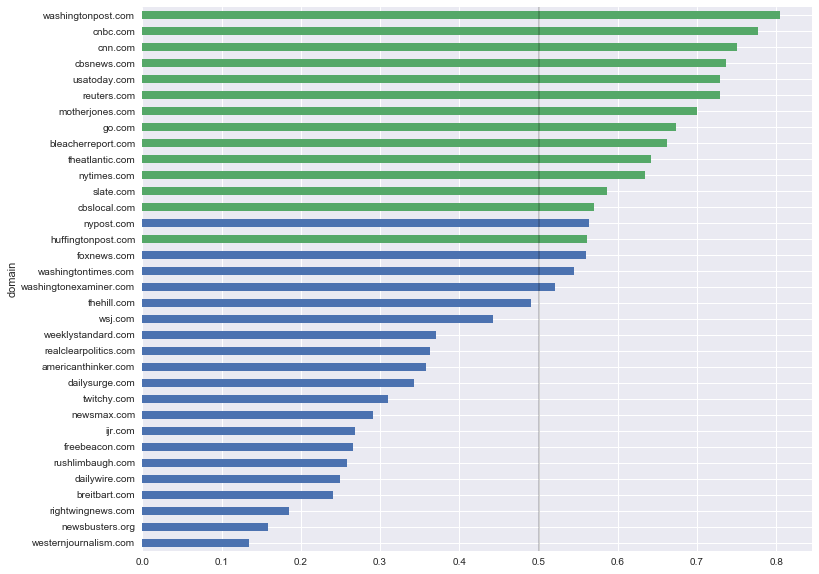

In [9]:
# Groupby domain name and take the average probability.  We can then round to 0/1 to 
# get a domain-level classification.

drop_less_than = 10  # Drop domains with fewer than this many observations

df_mean = df.groupby('domain')['encoded_label', 'prob'].mean()
df_count = df.groupby('domain')['domain'].count()
df_stats = pd.concat([df_mean, df_count], axis=1).sort_values('prob')
df_stats['num_correct'] = df_stats.apply(lambda x: int(np.round(x['prob'])) == x['encoded_label'], axis=1)
df_stats = df_stats[df_stats['domain'] >= drop_less_than]

colors = {0: sn.color_palette()[0], 1: sn.color_palette()[1]}

ax = df_stats['prob'].plot(kind='barh', figsize=(12, 10), color=[colors[i] for i in df_stats['encoded_label']])

ax = ax.axes.vlines(0.5, -19, 1000, alpha=.2)

In [10]:
# Count the number of correct domain-level classifications.
tf = df_stats.groupby('num_correct')['prob'].count()
print('Domain-level accuracy: {:1.1f}%'.format(100.*tf[True]/tf.sum()))

Domain-level accuracy: 88.2%


In [25]:
df[df['prob'] > 0.9]['domain'].value_counts()

cnn.com                   1336
washingtonpost.com        1141
cnbc.com                   470
usatoday.com               438
cbsnews.com                374
go.com                     260
theatlantic.com            209
nytimes.com                123
reuters.com                 79
washingtontimes.com         25
foxnews.com                 24
motherjones.com             19
washingtonexaminer.com      16
slate.com                   14
nypost.com                  13
huffingtonpost.com          10
newsmax.com                  6
thehill.com                  4
weeklystandard.com           4
breitbart.com                4
westernjournalism.com        3
realclearpolitics.com        3
rightwingnews.com            3
dailywire.com                2
bleacherreport.com           2
ijr.com                      2
cbslocal.com                 2
twitchy.com                  2
americanthinker.com          1
freebeacon.com               1
Name: domain, dtype: int64

In [12]:
df[df['prob'] < 0.01]['domain'].value_counts()

westernjournalism.com    305
rightwingnews.com        255
breitbart.com             33
dailywire.com             30
newsbusters.org           20
ijr.com                    6
realclearpolitics.com      6
newsmax.com                5
twitchy.com                5
freebeacon.com             3
americanthinker.com        2
weeklystandard.com         1
Name: domain, dtype: int64

In [13]:
df[df['prob'] > 0.99]['domain'].value_counts()

Series([], Name: domain, dtype: int64)

In [45]:
hi = df[df['prob'] > 0.9]
hi[hi['domain'] == 'theatlantic.com']['tokenized'].iloc[3]

u'can_VERB -PRON-_PRON ace_VERB the_DET atlantic_PROPN thanksgiving_PROPN turkey_PROPN quiz_PROPN'

In [85]:
lo = df[df['prob'] < 0.4]
lo.shape

(19596, 8)

In [86]:
lo[lo['domain'] == 'westernjournalism.com']['tokenized'].head(20)

253    unreal_NOUN on_ADP coldest_PROPN day_PROPN of_...
254    analysis_NOUN fall_PROPN of_ADP aleppo_PROPN s...
255    walk_VERB on_ADP stage_PROPN at_PROPN rally_PR...
256    what_NOUN george_PROPN bush_PROPN really_VERB ...
257    break_VERB add_VERB big_ADJ time_PROPN conserv...
258    in_ADP find_NOUN out_ADP what_NOUN china_PROPN...
259    the_DET medium_NOUN taught_PROPN -PRON-_PRON t...
260    in_ADP surprise_NOUN russia_PROPN announcement...
261    in_ADP right_ADJ before_ADP obama_PROPN leaves...
262    right_ADV before_ADP obama_PROPN leaves_PROPN ...
263    watch_NOUN during_ADP final_PROPN press_PROPN ...
264    watch_NOUN obama_PROPN year_PROPN end_PROPN pr...
265    watch_NOUN huckabee_PROPN can_VERB take_VERB -...
266    watch_NOUN tucker_PROPN carlson_PROPN ask_VERB...
267    a_DET day_NOUN after_ADP slams_PROPN major_PRO...
268    break_VERB obama_PROPN revealed_PROPN the_DET ...
269    krauthammer_PROPN drops_PROPN bombshell_PROPN ...
270    break_VERB fbi_PROPN dir

In [93]:
lo[lo['domain'] == 'westernjournalism.com']['tokenized'].ix[269]

u'krauthammer_PROPN drops_PROPN bombshell_PROPN many_ADJ thought_NOUN would_VERB never_ADV happen_VERB establishment_PROPN stun_VERB'

In [72]:
in_model, out_model = rnn.split_model_layers(model, topn, embed_dim, dense_dim, gru_dim, 1, maxlen, bidirectional)

In [94]:
rnn.evaluate_sequential_probs(X, 269, in_model, out_model)

array([ 0.04570071,  0.0203014 ,  0.00460583,  0.00565564,  0.00638276,
        0.00620504,  0.00651948,  0.00619915,  0.00553807,  0.00504821,
        0.00522823,  0.00528396,  0.00532334,  0.00534916,  0.00536744,
        0.00538037,  0.00538956,  0.00539623,  0.00540147,  0.00540572], dtype=float32)

In [48]:
df.ix[177, 'text']

u' Rep. Cummings asks Trump to soften talk about black communities Video - ABC News Sections Sections Top Stories Watch U.S. International Politics Lifestyle Entertainment Health Tech Investigative Sports Weather Shows Shows Good Morning America World News Tonight Nightline 20/20 This Week What Would You Do? Live Live Demonstrators react to court ruling on the impeached South Korean President RADAR: Severe weather and heavy snow across the East Sydney Opera House in Sydney Harbor Skiers hit the slopes in Copper Mountain, Colo. Penguin cam from the Kansas City Zoo in Missouri Bald eagle tends to her eaglet in Fort Myers, Fla. Ocean Voyager webcam at the Georgia Aquarium Barrier reef cam from the Georgia Aquarium Old Faithful geyser in Yellowstone National Park More Privacy Policy Your CA Privacy Rights Children\'s Online Privacy Policy Interest-Based Ads Terms of Use Contact Us Yahoo!-ABC News Network | \xa9 2017 ABC News Internet Ventures. All rights reserved. Search Menu ABC News Log 

In [51]:
df.ix[177, 'url']

u'http://abcnews.go.com/Politics/video/rep-cummings-asks-trump-soften-talk-black-communities-46016256'